# <font  color = "#0093AF"> Propagators and Sequences

Propagators are responsible for moving the density matrix, $\hat{\rho}(t)$ forward in time in magnetic resonance simulations. For a constant Liouvillian, the propagator, $\hat{\hat{U}}(t,t+\Delta t)$ is given by
\begin{equation}
\hat{\hat{U}}(t,t+\Delta t)=\exp(\hat{\hat{L}}(t)\Delta t)
\end{equation}
such that
\begin{equation}
\hat{\rho}(t+\Delta t)=\hat{\hat{U}}(t,t+\Delta t)\hat{\rho}(t)
\end{equation}
Of course, the Liouvillian is often not constant, either due to rotor spinning or a pulse sequence. In this case, the propagator is constructed as a product of piecewise constant propagators.

We start with generation of propagators without pulses, which can be produced directly with the Liouvillian.

## Setup

In [1]:
import os
os.chdir('../../../')
import SLEEPY as sl
import numpy as np

In [60]:
ex=sl.ExpSys(v0H=600,Nucs=['1H','13C','13C'],vr=60000)  #For this example, we'll work in the lab frame
ex.set_inter('dipole',i0=0,i1=1,delta=44000).set_inter('CSA',i=1,delta=100,eta=1).\
    set_inter('CS',i=0,ppm=10) #Add a dipole, CSA to 13C, and CS to 1H

ex1=ex.copy() #Copy the above
ex1.set_inter('dipole',i0=0,i1=1,delta=44000,euler=[0,30*np.pi/180,0])

L=sl.Liouvillian(ex,ex1,kex=sl.Tools.twoSite_kex(1e-5)) #Here, we produce the exchange matrix with twoSite_kex

## Propagators without pulses

We first generate the default propagator from the Liouvillian. These propagators do not have contributions from applied radio-frequency fields.

In [3]:
U=L.U()

U has a few key features: it has a starting time relative to the rotor period (t0), and a length(Dt). If unspecified when creating the propagator, the length is one rotor period (L.taur), since this helps makes computational speed faster. Defining Dt will override this length. If SLEEPY is not include, then Dt must be specified since the rotor period is no longer defined (note that even if spinning is specified in ex, if no anisotropic interactions are defined, then the rotor period becomes undefined and Dt must be specified).

U also has a starting time relative to the rotor period. This may also be specified, but if omitted, then t0 is set to ex.current_time (or L.expsys.current_time). ex.current_time is updated whenever a propagator is created, to match the time at the end of that propagator. Then, if propagators are created in the order in which they will be applied, they will always be created with the correct t0.

Unless we are not spinning, it is important that when multiplying propagators, that the end of the propagator to the right (the first to be applied in time) ends when the propagator to the left starts. That is, to calculate 
```
U1*U0
```
we require that `U0.tf%U0.taur==U1.t0` 
(% is the modulo operator, so this is the same point in the rotor period, although it is ok if U0.tf is multiple rotor periods after U1.t0, as long as they are equal modulo taur. Note that 'taur' is available in most SLEEPY objects, although defaults to None (has no value) if spinning is not included.

A density matrix also has a time associated with it, and to multiply
```
U*rho
```
we require, similarly, that `U.t0==rho.t%rho.taur`

Note that the current_time may be reset using L.reset_prop_time(t), where the default time, t, is zero.

We make an example where we generate two propagators, and see how their initial times are defined.

In [15]:
L.reset_prop_time()
U0=L.U(Dt=L.taur/3)
U1=L.U(Dt=L.taur*2/3)
print(f'U0: t0={U0.t0*1e6:.3f} us, tf={U0.tf*1e6:.3f} us, Dt={U0.Dt*1e6:.3f}')
print(f'U1: t0={U1.t0*1e6:.3f} us, tf={U1.tf*1e6:.3f} us, Dt={U1.Dt*1e6:.3f}')

U0: t0=0.000 us, tf=5.556 us, Dt=5.556
U1: t0=5.556 us, tf=16.667 us, Dt=11.111


Note that while the first propagator has t0=0, the second starts at 5.556 $\mu$s, when the previous propagator ended. If we take their product, we get a propagator with length of one rotor period.

In [16]:
U1*U0

Propagator with length of 16.667 microseconds (t0=0.000,tf=16.667)
Constructed from the following Liouvillian:
	Liouvillian under the following conditions:
		2-spin system (1H,13C)
		B0 = 14.092 T (600.000 MHz 1H frequency)
		rotor angle = 54.736 degrees
		rotor frequency = 60.0 kHz
		Temperature = 298 K
		Powder Average: JCP59 with 99 angles
	
	The individual Hamiltonians have the following interactions
		Hamiltonian #0
			dipole between spins 0,1 with arguments:
				(delta=44000.00)
			CSA on spin 1 with arguments: (delta=100.00,eta=1.00)
			CS on spin 0 with arguments: (ppm=10.00)
		
		Hamiltonian #1
			CSA on spin 1 with arguments: (delta=100.00,eta=1.00)
			CS on spin 0 with arguments: (ppm=10.00)
			dipole between spins 0,1 with arguments:
				(delta=44000.00,euler=[0.00,30.00,0.00])
		
		
	Hamiltonians are coupled by exchange matrix:
		array([[-50000.,  50000.],
		       [ 50000., -50000.]])
	

Note that if we multiply U0 by itself, we get a warning, since the end of U0 is not the same time as the beginning of U0 (relative to the rotor period)

In [17]:
_=U0*U0

/Users/albertsmith/Documents/GitHub.nosync/SLEEPY/Propagator.py:236: UserWarning: 
First propagator ends at 5.555555555555556e-06 but second propagator starts at 0.0
  warnings.warn(f'\nFirst propagator ends at {U.tf%self.taur} but second propagator starts at {self.t0%U.taur}')


As with the Hamiltonian and Liouvillian, propagators can also be plotted:

<AxesSubplot:>

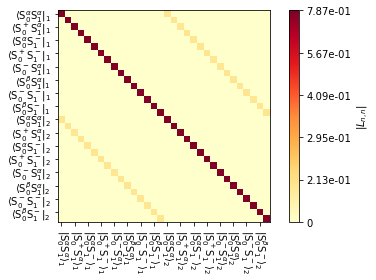

In [18]:
U0.plot()

### Special propagators

The Liouvillian can also produce propagators for $\delta$-pulses (i.e. pulses with zero length) and an identity propagator. Both types have zero length, and they can be multiplied with propagators ending at any time (they do acquire an initial time, but this is not checked). The identity propagator does not have any effect on other propagators or density matrices, but is occasionally useful as a kind of propagator pre-allocation.

<AxesSubplot:>

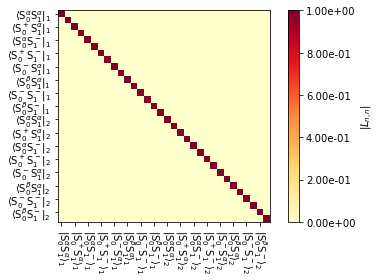

In [29]:
Ueye=L.Ueye()
Ueye.plot(mode='abs')

A $\delta$-pulse propagator needs to be provided with a channel ('13C','1H', etc.) or a spin-index (0,1,2). The spin-index will apply the pulse just to one spin, even if there are other spins of the same nucleus type. Obviously this is unphysical, but can be useful for creating selective pulses without actually fully simulating them.

The default flip angle for the $\delta$-pulse is a $\pi$-pulse with an 'x' phase, but adjusting phi (flip angle) and phase, any $\delta$-pulse may be obtained.

<AxesSubplot:>

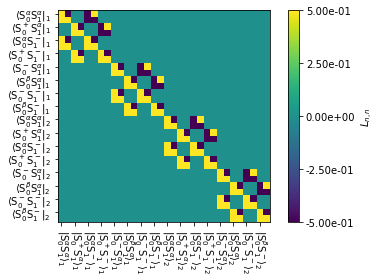

In [54]:
Ud=L.Udelta('13C',phi=np.pi/2,phase=np.pi/2)  #pi/2 y-pulse on 13C
Ud.plot(mode='re')

## Sequences

Of course, we would also like to be able to apply pulses for our propagators. This is achieved with the sequence object, which is also generated from the Liouvillian. 

Sequences are used to create propagators, although in some cases, propagators are only calculated internally within rho when used with a sequence.

We initialize a sequence by calling L.Sequence(). Usually, when we add channels to the sequence, we define a time-axis while doing so, which will then define the length of the sequence. However, it is possible to use the sequence to just define the amplitude of a continuously applied field. In this case, under spinning, the sequence length then becomes one rotor period by default. If no spinning is used, then this case requires initializing the sequency with a length (`Dt=1e-3` would, for example, make a 1 ms sequence).

Once a sequence is defined, we add channels to it. Channels may be added the usual way, by specifying the nucleus, but they may also be added to a specific spin by index.

In [71]:
seq=L.Sequence()

We start with a sequence that has no time axis, just a constant field applied to $^{13}$C, applied in the *y*-direction. We use `seq.plot()` to visualize the result.

[<AxesSubplot:ylabel='$v_1$ / kHz'>,
 <AxesSubplot:xlabel='t / $\\mu$s', ylabel='$v_1$ / kHz'>]

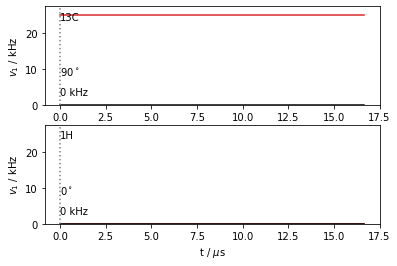

In [72]:
seq.add_channel('13C',v1=25000,phase=np.pi/2)
seq.plot()

Alternatively, we may use pulses. We may overwrite the existing channels, or just create a new sequence (here we overwrite the $^{13}$C channel by calling it without any arguments (the default for v1 is 0). Note that the 'add_channel' function returns itself, so we can string together multiple calls to seq.

[<AxesSubplot:ylabel='$v_1$ / kHz'>,
 <AxesSubplot:xlabel='t / $\\mu$s', ylabel='$v_1$ / kHz'>]

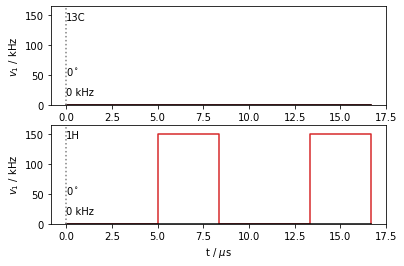

In [73]:
v1=150000
tpi=1/v1/2
t=[0,L.taur/2-tpi,L.taur/2,L.taur-tpi,L.taur]
seq.add_channel('13C').add_channel('1H',t=t,v1=[0,v1,0,v1]).plot()

Note that this setup lets us easily create shaped pulses by just providing a time axis and an amplitude. 